# Simulation
This notebook will be used to import available S-parameter data from the BFP640 and simulate/verify the single-gain stage behaviour using scikit-RF.

The simulation was done after construction, since only then I realized that LTSpice was really not up to this kind-of job.

### DC Operating point

In [20]:
import sys
sys.path.insert(0,'../python_libs')

from rf_simulations import load_s2p_files, find_bounding_networks

### Checking DC Operating point (U3)
DC_VBase_U3 = 1.12  		#! SIM VALUE: 1.23 V
DC_VEmitter_U3 = 0.68		#! SIM VALUE: 0.436 V
DC_VCollector_U3 = 2.04		#! SIM VALUE: 3.15 V
DC_IEmitter_U3 = DC_VCollector_U3 / 47
DC_Vbe_U3 = DC_VBase_U3 - DC_VEmitter_U3
DC_Vce_U3 = DC_VCollector_U3 - DC_VEmitter_U3

print(f"VBE - U3 {DC_Vce_U3:.2f} V")
print(f"VCE - U3 {DC_Vce_U3:.2f} V")
DC_IEmitter_U3_mA = DC_IEmitter_U3 * 1000
print(f"IE/IC  - U3 {DC_IEmitter_U3_mA:.2f} mA")

### Dictionary set
# Look for the value closest to Vce, Ic (1 higher and 1 lower)

DATA_DIR = '/home/iwolfs/Work/Projects/rf_lna_project/other/s_params/SPAR/BFP640'
networks = load_s2p_files(DATA_DIR)
print(f"Loaded {len(networks)} networks.")

VBE - U3 1.36 V
VCE - U3 1.36 V
IE/IC  - U3 43.40 mA
Loading files from: /home/iwolfs/Work/Projects/rf_lna_project/other/s_params/SPAR/BFP640
list directory: ['BFP640_w_noise_VCE_1.0V_IC_40mA.s2p', 'BFP640_w_noise_VCE_3.0V_IC_12mA.s2p', 'BFP640_w_noise_VCE_3.5V_IC_30mA.s2p', 'BFP640_VCE_3.0V_IC_48mA.s2p', 'BFP640_w_noise_VCE_1.0V_IC_20mA.s2p', 'BFP640_w_noise_VCE_4.0V_IC_6.0mA.s2p', 'BFP640_VCE_1.0V_IC_32mA.s2p', 'BFP640_w_noise_VCE_2.5V_IC_8.0mA.s2p', 'BFP640_w_noise_VCE_1.0V_IC_5.0mA.s2p', 'BFP640_w_noise_VCE_3.0V_IC_15mA.s2p', 'BFP640_VCE_3.0V_IC_18mA.s2p', 'BFP640_VCE_2.5V_IC_28mA.s2p', 'BFP640_w_noise_VCE_2.0V_IC_40mA.s2p', 'BFP640_VCE_1.0V_IC_37mA.s2p', 'BFP640_w_noise_VCE_4.0V_IC_35mA.s2p', 'BFP640_w_noise_VCE_2.5V_IC_2.0mA.s2p', 'BFP640_w_noise_VCE_3.0V_IC_2.0mA.s2p', 'BFP640_VCE_3.5V_IC_50mA.s2p', 'BFP640_VCE_1.5V_IC_18mA.s2p', 'BFP640_w_noise_VCE_4.0V_IC_1.0mA.s2p', 'BFP640_w_noise_VCE_3.5V_IC_45mA.s2p', 'BFP640_w_noise_VCE_2.5V_IC_10mA.s2p', 'BFP640_VCE_3.5V_IC_18mA.s2p', 'B

### Checking variety of S-parameters within noisy-noiseless
Quickly plot out the combination of s-parameters for
- Only the noisy data-sets
- Only the noiseless data-sets
- The same Vce parameters
- The same Ic parameters

In order to see whether the noise vs noiseless parameters have a big effect on the dataset, just in case there is a difference in test-setup.

The biggest impact seems to come from the big jump in voltage.

corners: [(1.0, 42.0, 0), (1.0, 45.0, 1), (1.5, 42.0, 0), (1.5, 45.0, 1)]
dict {(1.0, 42.0, 0): 2-Port Network: 'BFP640_VCE_1.0V_IC_42mA',  0.03-10.0 GHz, 99 pts, z0=[50.+0.j 50.+0.j], (1.0, 45.0, 1): 2-Port Network: 'BFP640_w_noise_VCE_1.0V_IC_45mA',  0.03-10.0 GHz, 99 pts, z0=[50.+0.j 50.+0.j], (1.5, 42.0, 0): 2-Port Network: 'BFP640_VCE_1.5V_IC_42mA',  0.03-10.0 GHz, 99 pts, z0=[50.+0.j 50.+0.j], (1.5, 45.0, 1): 2-Port Network: 'BFP640_w_noise_VCE_1.5V_IC_45mA',  0.03-10.0 GHz, 99 pts, z0=[50.+0.j 50.+0.j]}


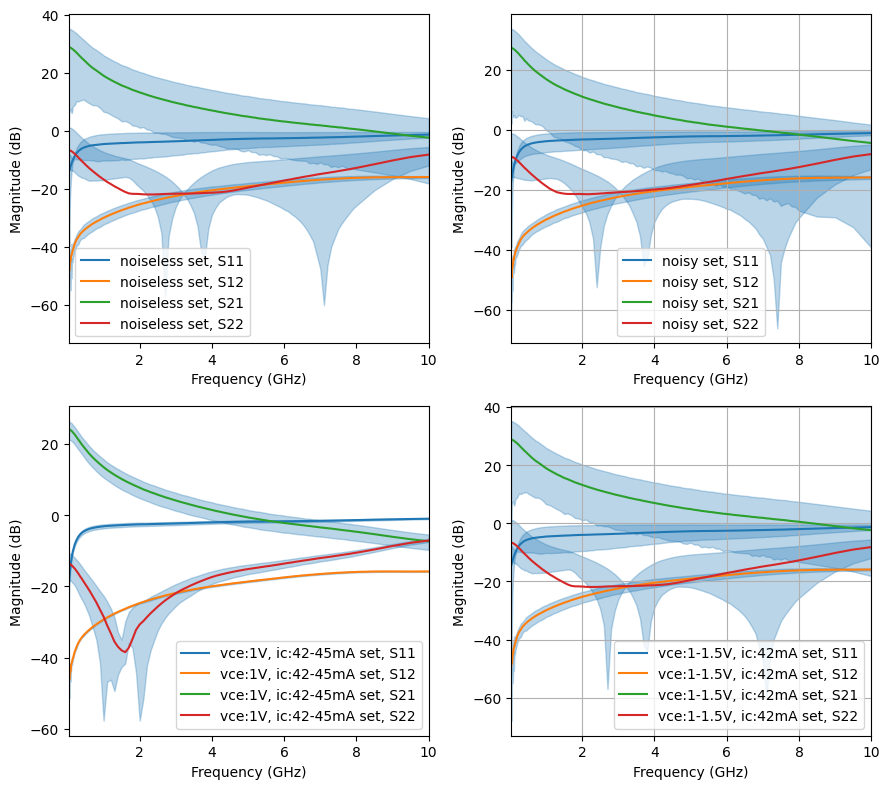

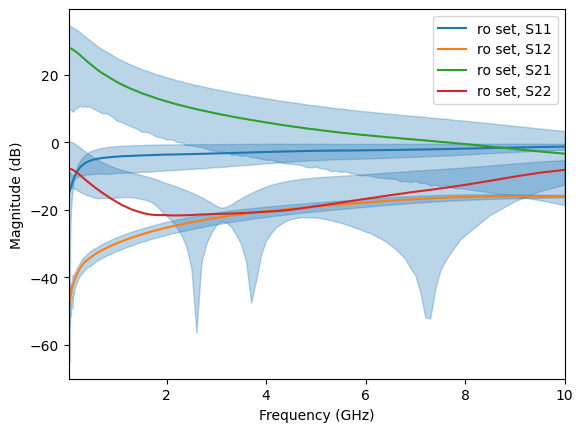

In [21]:
import matplotlib.pyplot as plt
import skrf as rf

filtered_networks = find_bounding_networks(
	networks,
	vce_target=DC_Vce_U3,
	ic_target=DC_IEmitter_U3_mA)

ro_ns = rf.NetworkSet(filtered_networks, name='ro set')
print(f"dict {filtered_networks}")

noiseless_dict =  {k: v for k, v in filtered_networks.items() if k[2] == 0}
ro_ns_noiseless = rf.NetworkSet(noiseless_dict, name ='noiseless set')
noisy_dict =  {k: v for k, v in filtered_networks.items() if k[2]}
ro_ns_noisy= rf.NetworkSet(noisy_dict, name ='noisy set')
vce_const_dict = {k: v for k, v in filtered_networks.items() if k[0] == 1.0}
ro_ns_vce_1V= rf.NetworkSet(vce_const_dict, name ='vce:1V, ic:42-45mA set')
ic_const_dict = {k: v for k, v in filtered_networks.items() if k[1] == 42.0}
ro_ns_ic_42mA= rf.NetworkSet(ic_const_dict, name ='vce:1-1.5V, ic:42mA set')

fig = plt.figure(figsize=(9,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222); ax2.grid()
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224); ax4.grid()

ro_ns_noiseless.plot_uncertainty_bounds_s_db(ax=ax1)
ro_ns_noisy.plot_uncertainty_bounds_s_db(ax=ax2)
ro_ns_vce_1V.plot_uncertainty_bounds_s_db(ax=ax3)
ro_ns_ic_42mA.plot_uncertainty_bounds_s_db(ax=ax4)
fig.tight_layout()
plt.show()
ro_ns.plot_uncertainty_bounds_s_db()
plt.show()


### Interpolation
The function below performs interpolation between 2-4 different circuits (depending on how much are present in the dictionary).

/home/iwolfs/Work/Projects/rf_lna_project/RF-lna-project/pyenv/lib/python3.12/site-packages/skrf/mathFunctions.py:268: RuntimeWarning: divide by zero encountered in log10
  out = 20 * np.log10(z)


[]

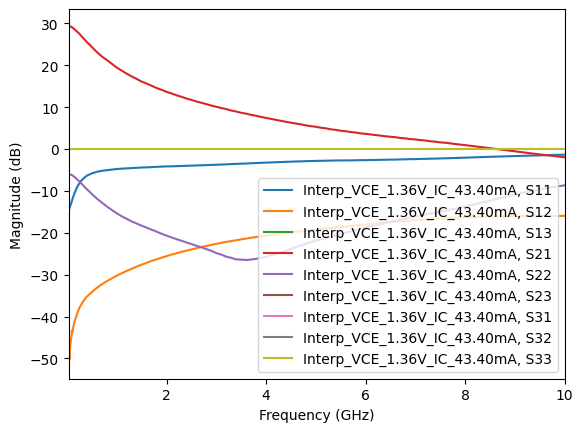

In [22]:
import sys
sys.path.insert(0,'../python_libs')
from rf_simulations import interpolate_2d_network, convert_to_3port_with_grounded_emitter

U3 = interpolate_2d_network(filtered_networks, DC_Vce_U3, DC_IEmitter_U3_mA, interp_kind='linear')
# U3.plot_s_db()
# plt.plot()
U3_3p_ce = convert_to_3port_with_grounded_emitter(U3)
U3_3p_ce.plot_s_db()
plt.plot()

### Scikit-RF simulation
We'll model the single-gain stage using the interpolated network.

#### Transforming the S-parameters for the common-emitter
Since we're performing emitter degeneration to get some negative feedback, we need to take that into account when creating our S-parameter model.
So let's turn the 2-port system into a 3-port system with the grounded emitter (as it was originally measured), and add the emitter degeneration.

0.5-1.2 GHz, 8 pts


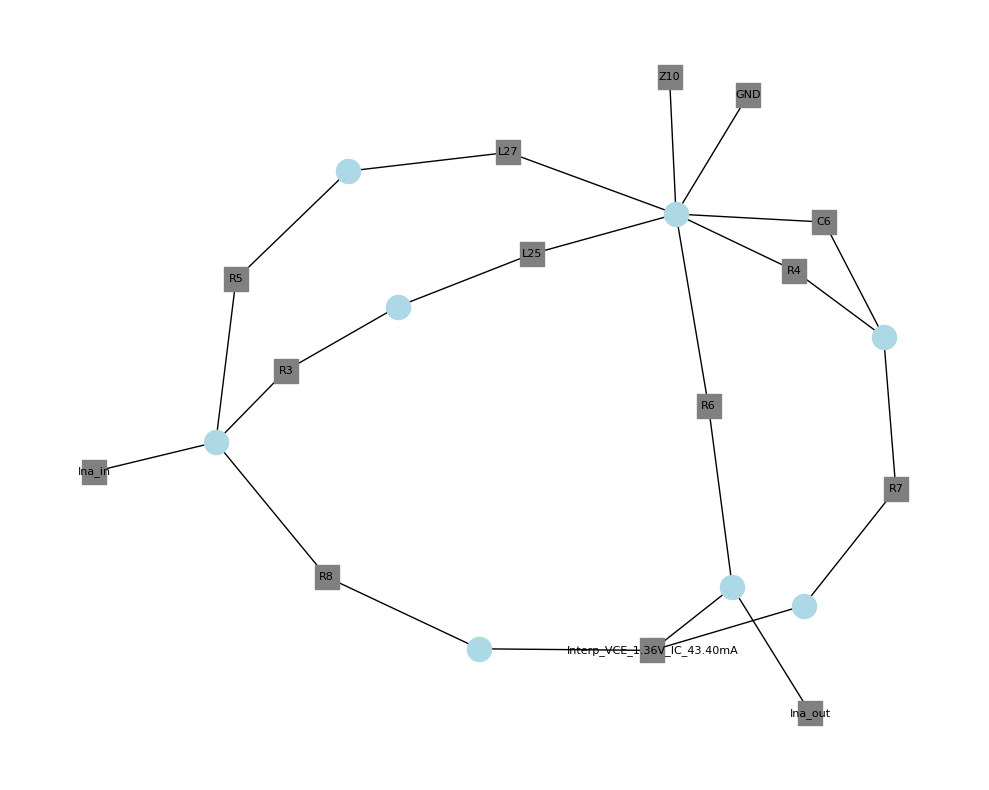

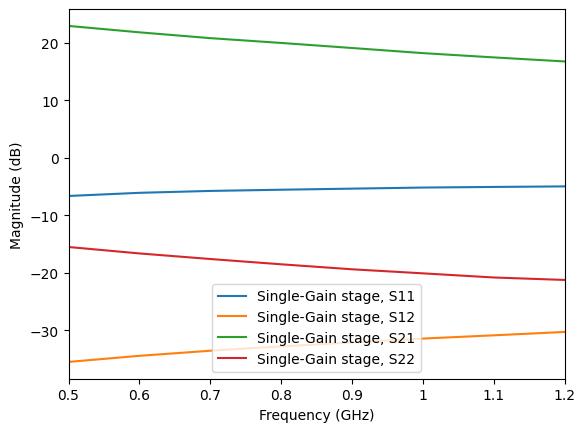

In [27]:
import sys
sys.path.insert(0,'../python_libs')
from rf_simulations import interpolate_2d_network, convert_to_3port_with_grounded_emitter


import numpy as np
import skrf as rf
from skrf.media import DefinedGammaZ0
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Media
Z0 = 50
f_low, f_high = 500e6, 1200e6 #! Matching range
f_low_str, f_high_str = '500MHz', '1200MHz'

#! COMPONENTS
### TRANSISTORS
U3_3p = U3_3p_ce[f'{f_low_str}-{f_high_str}'] # Convert to 3-port with grounded emitter (port 2 -> emitter)
freq = U3_3p.frequency  # scikit-rf Frequency object
print(freq)
### Transmission Line Medium
line = DefinedGammaZ0(frequency=freq, z0=Z0, gamma=0j)  # zero gamma => ideal lumps

## RESISTORS
R3 = line.resistor(1e3, frequency=freq, name='R3')
R4 = line.resistor(47, frequency=freq, name='R4')
R5 = line.resistor(330, frequency=freq, name='R5')
R6 = line.resistor(200, frequency=freq, name='R6')
R7 = line.resistor(0, frequency=freq, name='R7')  # Short circuit
R8 = line.resistor(0, frequency=freq, name='R8')  # Short circuit

## INDUCTORS
L25 = line.inductor(160e-9, frequency=freq, name='L25')
L27 = line.inductor(160e-9, frequency=freq, name='L27')


## CAPACITORS
C6 = line.capacitor(100e-12, frequency=freq, name='C6')

## MATCHING COMPONENTS
Z8 = line.capacitor(1e-12, frequency=freq, name='Z8')
Z9 = line.capacitor(1e-12, frequency=freq, name='Z9')
Z10 = line.resistor(24e-12, frequency=freq, name='Z10') # Assuming a value for DNP component for simulation
Z12 = line.capacitor(1e-12, frequency=freq, name='Z12')
# Z14 = line.inductor(16e-9, frequency=freq, name='Z14') # Assuming a value for DNP component for simulation
Z16 = line.capacitor(6.8e-12, frequency=freq, name='Z16')

## PORTS / GND
J2 = rf.Circuit.Port(frequency=freq, name='Ina_in', z0=Z0)
J3 = rf.Circuit.Port(frequency=freq, name='Ina_out', z0=Z0)
GND = rf.Circuit.Ground(frequency=freq, name='GND', z0=Z0)

#! CIRCUIT

INPUT_MATCH = False
OUTPUT_MATCH = False

connections = [
	## U3
	# Base
	[(R8, 1), (U3_3p, 0)],
	
	# Collector 

	# Emitter
	[(R7, 0), (U3_3p, 2)],
	[(R7, 1), (R4, 0), (C6, 0)],
	
	# Biasing circuits
	[(R3, 1), (L25, 0)],
	[(R5, 1), (L27, 0)],	

	# Ground connections
	[(L25, 1), (L27, 1), (R6, 1), (R4, 1), (C6, 1), (Z10, 1), (GND, 0)]
]
# INPUT / MATCHING
if (INPUT_MATCH):
	connections.append([(J2, 0), (Z12, 0)])
	connections.append([(Z12, 1), (Z16, 0)])
	connections.append([(Z16, 1), (R8, 0), (R3, 0), (R5, 0)])
else:
	connections.append([(J2, 0), (R8, 0), (R3, 0), (R5, 0)])
	
if (OUTPUT_MATCH):
	connections.append([(R6, 0), (Z8, 0), (U3_3p, 1)])
	connections.append([(Z8, 1), (Z10, 0), (Z9, 0)])
	connections.append([(Z9, 1), (J3, 0)])
else:
	connections.append([(R6, 0), (J3, 0), (U3_3p, 1)])

ckt = rf.Circuit(connections, name='Single-Gain stage', frequency=freq)

ckt.plot_graph(network_labels=True, network_fontsize=8,
               port_labels=True, port_fontsize=8)
plt.show()
ckt.network.plot_s_db()


### Conclusion
It seems like the best way to actually match circuits like this is simply
- Make sure your circuit (transistors) operate in the right (linear) region
- Make sure to anticipate space for damping resistors
- Bypass the impedance matching circuit initially (just leave a small cap for DC blocking purposes)
- Match later.